# GFP stats and ideal number of microstates

Analysis of number GFP peaks and ideal number of canonical microstates.

In [1]:
%matplotlib inline

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

from src.helpers import PLOTS_ROOT, RESULTS_ROOT, make_dirs

plt.rcParams["figure.figsize"] = (20, 9)
plt.style.use("default_light")
plt.rcParams["legend.frameon"] = False

WORKING_DIR = os.path.join(RESULTS_ROOT, "gfp_and_no_mstates")
PLOTTING_DIR = os.path.join(PLOTS_ROOT, "gfp_and_no_mstates")
make_dirs(PLOTTING_DIR)

# if True, will save all statistical tests as csv and all plots as eps
SAVE_RESULTS = False
PLOT_EXT = ".eps"
# which correction for multiple comparisons should be used
MULTI_CORRECTION = "fdr_by"

In [2]:
# load data computed with `1-main_gfp_stats_and_ideal_no_mstates.py`
df = pd.read_csv(os.path.join(WORKING_DIR, "gfp_peaks_var_test.csv"), index_col=[0])
# divide session into PLA/PSI and time for plotting purposes
df[["condition", "time"]] = df["session"].str.split("-", expand=True)
# divide to filters
df_220 = df[df["filter"] == "(2.0, 20.0)"]
df_140 = df[df["filter"] == "(1.0, 40.0)"]

In [3]:
def _plot_ttest_signi(where, df_for_max, ax, x1_base=-0.2, x2_base=0.2):
    y = df_for_max.max() * 1.02
    h = df_for_max.max() * 0.05
    col = plt.rcParams["text.color"]
    for _, row in where.iterrows():
        pos = int(row["time"][-1]) - 1
        x1, x2 = x1_base + pos, x2_base + pos
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, c=col)
        if row["p-corr"] < 0.001:
            text = "p < 0.000"
        else:
            text = f"p={row['p-corr']:.3f}"
        ax.text(
            (x1 + x2) * 0.5,
            y + h,
            text,
            ha="center",
            va="bottom",
            color=col,
        )

## Number of GFP peaks

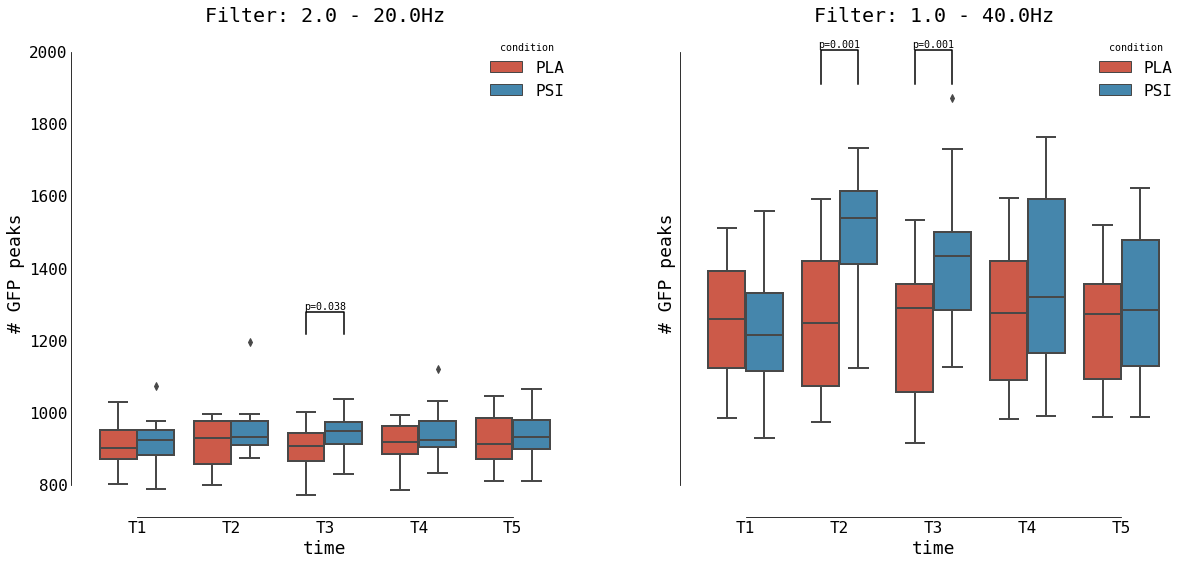

In [4]:
_, axs = plt.subplots(1, 2, sharey=True)
sns.boxplot(x="time", y="# GFP peaks", hue="condition", data=df_220, ax=axs[0])
axs[0].set_title("Filter: 2.0 - 20.0Hz")
sign = pg.pairwise_ttests(
    data=df_220,
    dv="# GFP peaks",
    within=["time", "condition"],
    subject="subject",
    padjust=MULTI_CORRECTION,
)
# find significant
where = sign[(sign["p-corr"] <= 0.05) & (sign["Contrast"] == "time * condition")]
_plot_ttest_signi(where, df_220["# GFP peaks"], ax=axs[0], x1_base=-0.2, x2_base=0.2)

bplot = sns.boxplot(x="time", y="# GFP peaks", hue="condition", data=df_140, ax=axs[1])
axs[1].set_title("Filter: 1.0 - 40.0Hz")
sign = pg.pairwise_ttests(
    data=df_140,
    dv="# GFP peaks",
    within=["time", "condition"],
    subject="subject",
    padjust=MULTI_CORRECTION,
)
# find significant
where = sign[(sign["p-corr"] <= 0.05) & (sign["Contrast"] == "time * condition")]
_plot_ttest_signi(where, df_140["# GFP peaks"], ax=axs[1], x1_base=-0.2, x2_base=0.2)
sns.despine(trim=True)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(PLOTTING_DIR, f"num_gfp_boxplot{PLOT_EXT}"),
        bbox_inches="tight",
        transparent=True,
    )

### ANOVA and posthoc for 2-20Hz filter

In [5]:
norm = pg.normality(data=df_220, dv="# GFP peaks", group="session")
if SAVE_RESULTS:
    norm.round(5).to_csv(os.path.join(WORKING_DIR, "gfp_peaks_2-20filt_normality.csv"))
norm

,W,pval,normal
PLA-T1,0.986939,0.996698,True
PLA-T2,0.909246,0.131853,True
PLA-T3,0.966941,0.810454,True
PLA-T4,0.921630,0.203974,True
PLA-T5,0.954437,0.596813,True
PSI-T1,0.956290,0.628252,True
PSI-T2,0.768866,0.001506,False
PSI-T3,0.984194,0.990331,True
PSI-T4,0.950478,0.532010,True
PSI-T5,0.984157,0.990212,True


In [6]:
# repeated measures ANOVA
anova = pg.rm_anova(
    data=df_220, dv="# GFP peaks", within=["time", "condition"], subject="subject"
)
if SAVE_RESULTS:
    anova.round(5).to_csv(os.path.join(WORKING_DIR, "gfp_peaks_2-20filt_rm_anova.csv"))
anova

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,6565.306667,4,56,1641.326667,2.120377,0.090282,0.108989,0.131534,0.781420
1,condition,26693.340000,1,14,26693.340000,7.091188,0.018555,0.018555,0.336216,1.000000
2,time * condition,7862.826667,4,56,1965.706667,1.688229,0.165576,0.192682,0.107611,0.638426


In [7]:
posthoc = pg.pairwise_ttests(
    data=df_220,
    dv="# GFP peaks",
    within=["time", "condition"],
    subject="subject",
    alpha=0.05,
    padjust=MULTI_CORRECTION,
    return_desc=True,
)
if SAVE_RESULTS:
    posthoc.round(5).to_csv(os.path.join(WORKING_DIR, "gfp_peaks_2-20filt_posthoc.csv"))
posthoc

,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,time,-,T1,T2,915.266667,58.601824,933.800000,59.976126,True,True,-3.058152,14.0,two-sided,0.008511,0.249284,fdr_by,6.361,-0.304124
1,time,-,T1,T3,915.266667,58.601824,921.466667,55.731328,True,True,-0.770998,14.0,two-sided,0.453525,1.000000,fdr_by,0.34,-0.105491
2,time,-,T1,T4,915.266667,58.601824,927.866667,63.449211,True,True,-1.627551,14.0,two-sided,0.125909,1.000000,fdr_by,0.771,-0.200732
3,time,-,T1,T5,915.266667,58.601824,930.366667,65.779791,True,True,-1.811487,14.0,two-sided,0.091568,1.000000,fdr_by,0.972,-0.235847
4,time,-,T2,T3,933.800000,59.976126,921.466667,55.731328,True,True,1.514644,14.0,two-sided,0.152110,1.000000,fdr_by,0.674,0.207280
5,time,-,T2,T4,933.800000,59.976126,927.866667,63.449211,True,True,0.883908,14.0,two-sided,0.391673,1.000000,fdr_by,0.368,0.093509
6,time,-,T2,T5,933.800000,59.976126,930.366667,65.779791,True,True,0.444887,14.0,two-sided,0.663202,1.000000,fdr_by,0.286,0.053071
7,time,-,T3,T4,921.466667,55.731328,927.866667,63.449211,True,True,-1.117967,14.0,two-sided,0.282399,1.000000,fdr_by,0.447,-0.104279
8,time,-,T3,T5,921.466667,55.731328,930.366667,65.779791,True,True,-1.238348,14.0,two-sided,0.235950,1.000000,fdr_by,0.501,-0.142045
9,time,-,T4,T5,927.866667,63.449211,930.366667,65.779791,True,True,-0.457253,14.0,two-sided,0.654504,1.000000,fdr_by,0.288,-0.037639


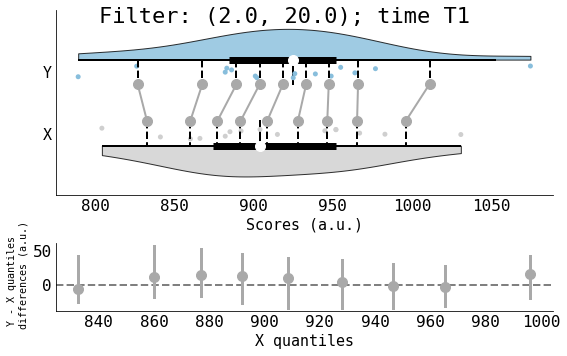

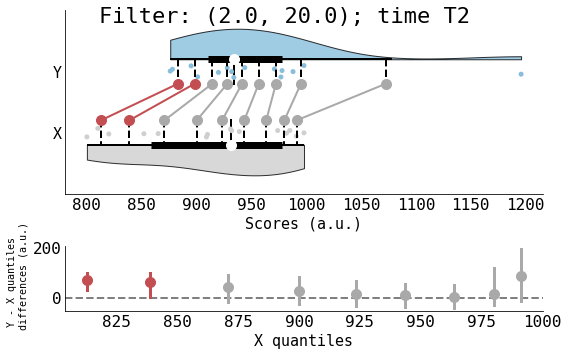

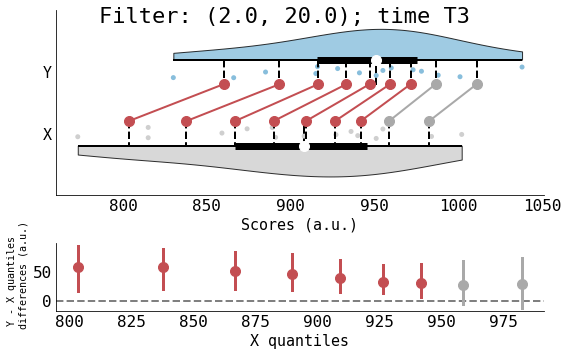

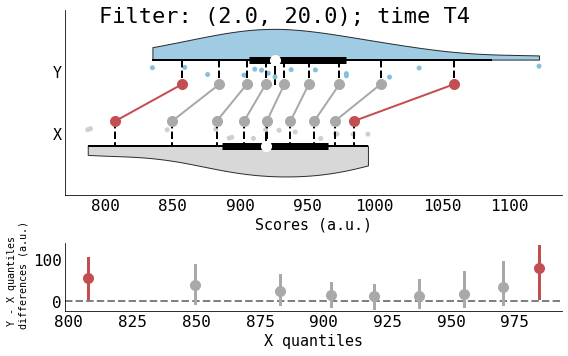

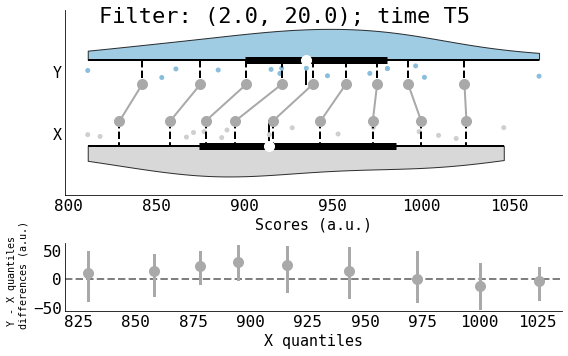

In [8]:
for time in ["T1", "T2", "T3", "T4", "T5"]:
    pg.plot_shift(
        df_220[df_220["session"] == f"PLA-{time}"]["# GFP peaks"],
        df_220[df_220["session"] == f"PSI-{time}"]["# GFP peaks"],
        paired=True,
    )
    plt.suptitle(f"Filter: (2.0, 20.0); time {time}")
    if SAVE_RESULTS:
        plt.savefig(
            os.path.join(PLOTTING_DIR, f"num_gfp_shiftplot_2-20filt_{time}{PLOT_EXT}"),
            bbox_inches="tight",
            transparent=True,
        )

### ANOVA and posthoc for 1-40Hz filter

In [9]:
norm = pg.normality(data=df_140, dv="# GFP peaks", group="session")
if SAVE_RESULTS:
    norm.round(5).to_csv(os.path.join(WORKING_DIR, "gfp_peaks_1-40filt_normality.csv"))
norm

,W,pval,normal
PLA-T1,0.945788,0.460714,True
PLA-T2,0.912657,0.148728,True
PLA-T3,0.946692,0.473934,True
PLA-T4,0.939924,0.381410,True
PLA-T5,0.945081,0.450561,True
PSI-T1,0.989942,0.999387,True
PSI-T2,0.931950,0.291754,True
PSI-T3,0.954937,0.605237,True
PSI-T4,0.915954,0.167069,True
PSI-T5,0.954801,0.602953,True


In [10]:
# repeated measures ANOVA
anova = pg.rm_anova(
    data=df_140,
    dv="# GFP peaks",
    within=["time", "condition"],
    subject="subject",
)
if SAVE_RESULTS:
    anova.round(5).to_csv(os.path.join(WORKING_DIR, "gfp_peaks_1-40filt_rm_anova.csv"))
anova

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,time,319856.706667,4,56,79964.176667,10.358234,0.000002,0.000254,0.425246,0.549911
1,condition,522504.060000,1,14,522504.060000,49.893562,0.000006,0.000006,0.780886,1.000000
2,time * condition,349957.773333,4,56,87489.443333,8.622207,0.000017,0.000145,0.381139,0.746847


In [11]:
posthoc = pg.pairwise_ttests(
    data=df_140,
    dv="# GFP peaks",
    within=["time", "condition"],
    subject="subject",
    alpha=0.05,
    padjust=MULTI_CORRECTION,
    return_desc=True,
)
if SAVE_RESULTS:
    posthoc.round(5).to_csv(os.path.join(WORKING_DIR, "gfp_peaks_1-40filt_posthoc.csv"))
posthoc

,Contrast,time,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,time,-,T1,T2,1244.900000,163.205633,1376.266667,165.610544,True,True,-5.774157,14.0,two-sided,0.000048,0.001411,fdr_by,545.772,-0.777412
1,time,-,T1,T3,1244.900000,163.205633,1324.033333,192.756551,True,True,-4.589327,14.0,two-sided,0.000421,0.006164,fdr_by,81.66,-0.431117
2,time,-,T1,T4,1244.900000,163.205633,1302.466667,221.587976,True,True,-2.884402,14.0,two-sided,0.012006,0.070333,fdr_by,4.794,-0.287827
3,time,-,T1,T5,1244.900000,163.205633,1264.566667,176.468620,True,True,-1.423131,14.0,two-sided,0.176600,0.574727,fdr_by,0.608,-0.112582
4,time,-,T2,T3,1376.266667,165.610544,1324.033333,192.756551,True,True,2.130482,14.0,two-sided,0.051348,0.187995,fdr_by,1.506,0.282819
5,time,-,T2,T4,1376.266667,165.610544,1302.466667,221.587976,True,True,2.158341,14.0,two-sided,0.048753,0.187995,fdr_by,1.567,0.367081
6,time,-,T2,T5,1376.266667,165.610544,1264.566667,176.468620,True,True,3.821162,14.0,two-sided,0.001871,0.018267,fdr_by,22.665,0.635095
7,time,-,T3,T4,1324.033333,192.756551,1302.466667,221.587976,True,True,1.011498,14.0,two-sided,0.328941,0.963459,fdr_by,0.407,0.101042
8,time,-,T3,T5,1324.033333,192.756551,1264.566667,176.468620,True,True,2.900177,14.0,two-sided,0.011638,0.070333,fdr_by,4.918,0.313106
9,time,-,T4,T5,1302.466667,221.587976,1264.566667,176.468620,True,True,2.433419,14.0,two-sided,0.028952,0.141333,fdr_by,2.358,0.184100


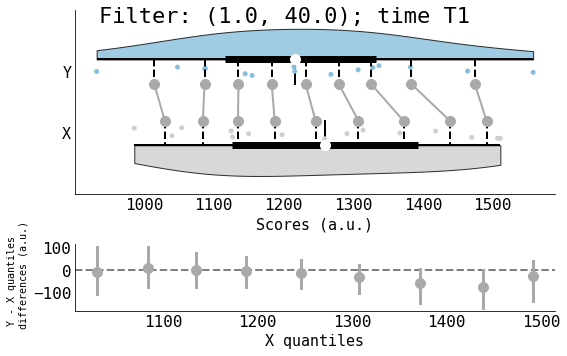

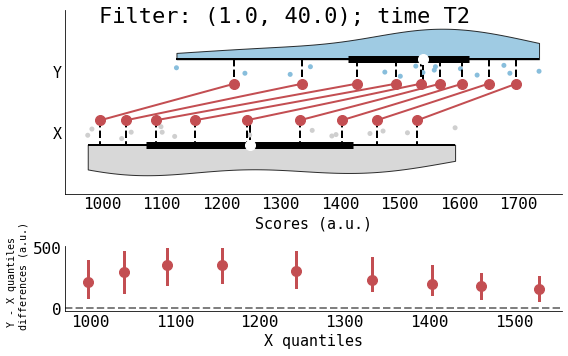

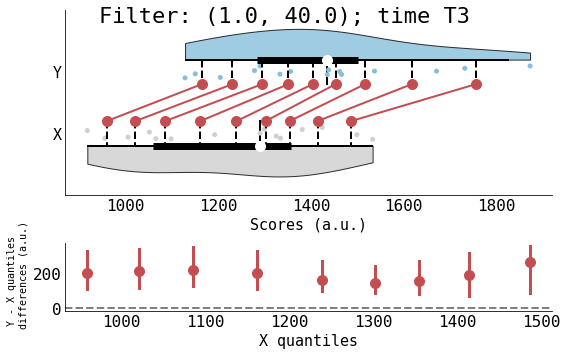

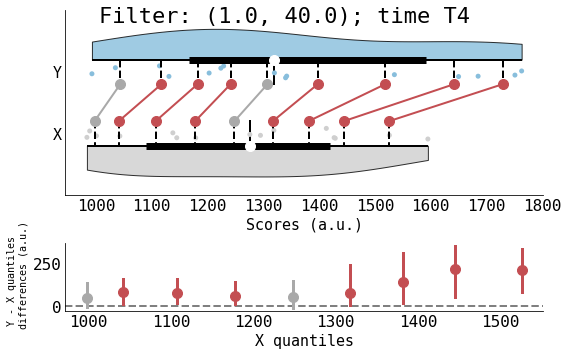

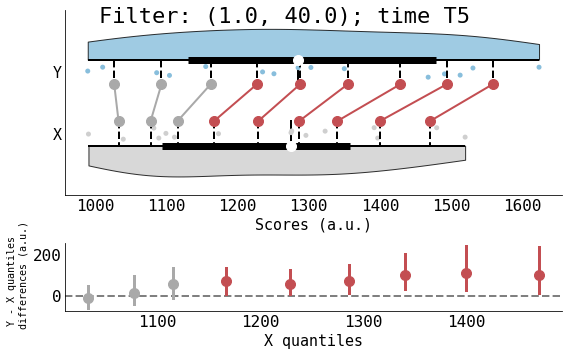

In [12]:
for time in ["T1", "T2", "T3", "T4", "T5"]:
    pg.plot_shift(
        df_140[df_140["session"] == f"PLA-{time}"]["# GFP peaks"],
        df_140[df_140["session"] == f"PSI-{time}"]["# GFP peaks"],
        paired=True,
    )
    plt.suptitle(f"Filter: (1.0, 40.0); time {time}")
    if SAVE_RESULTS:
        plt.savefig(
            os.path.join(PLOTTING_DIR, f"num_gfp_shiftplot_1-40filt_{time}{PLOT_EXT}"),
            bbox_inches="tight",
            transparent=True,
        )

## Ideal number of canonical microstates

### 2-20Hz filter

In [13]:
df_220_sigma = df_220.set_index(["subject", "condition", "time"]).filter(
    like="sigma_MCV GFP"
)

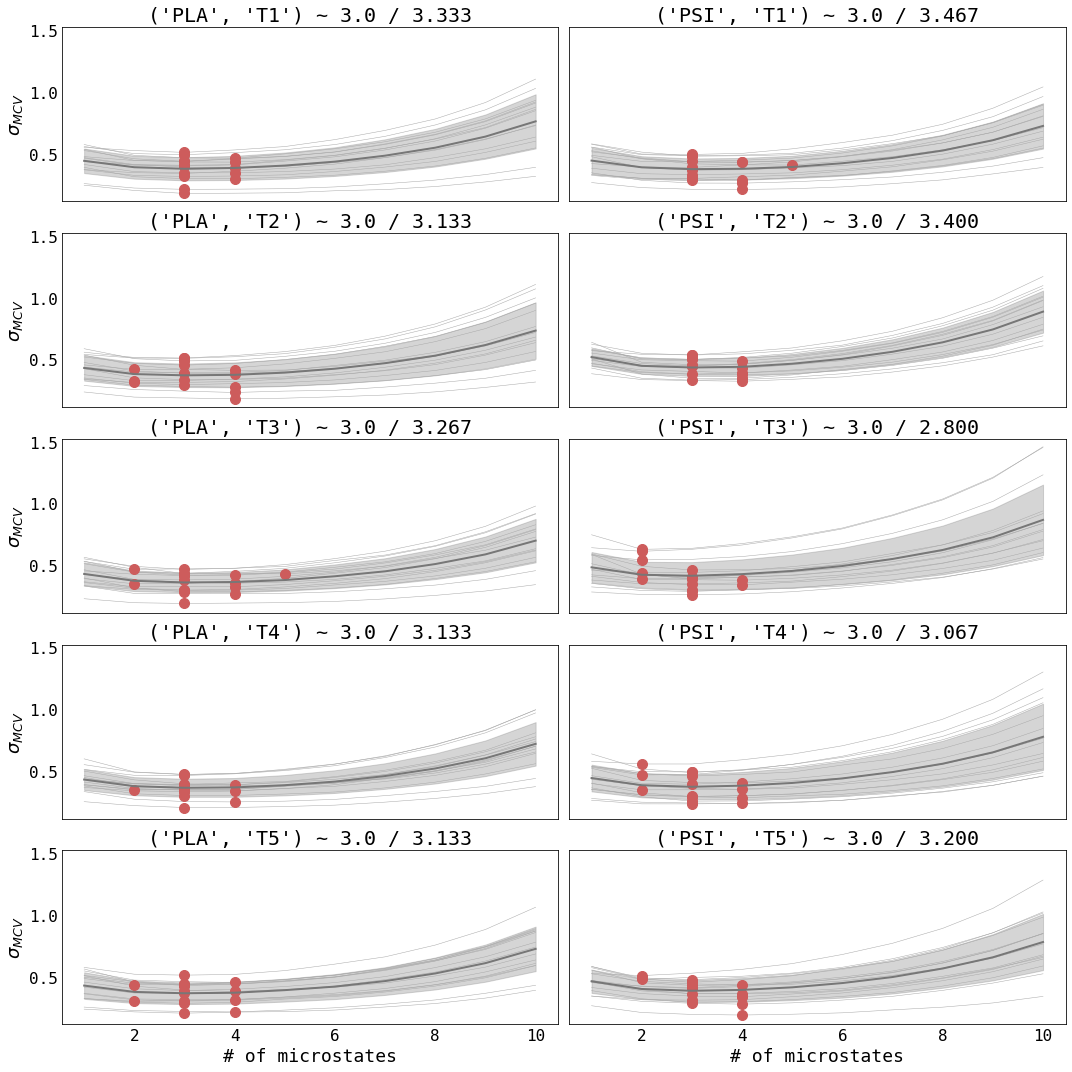

In [14]:
no_states = np.arange(1, df_220_sigma.values.shape[1] + 1)
_, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(15, 15))
ideal_ms = pd.DataFrame(columns=["session", "ideal #"])

for i, (session, df_temp) in enumerate(df_220_sigma.groupby(level=[1, 2])):
    sigmas = df_temp.values  # (subjs x no states)
    ideal_num = sigmas.argmin(axis=1) + 1
    ideal_ms.loc[i] = [session, np.median(ideal_num)]
    jj = 0 if session[0] == "PLA" else 1
    ii = int(session[1][-1]) - 1
    axs[ii, jj].plot(no_states, sigmas.T, color="#AAAAAA", linewidth=0.5)
    axs[ii, jj].plot(ideal_num, sigmas.min(axis=1), "o", color="indianred")
    axs[ii, jj].plot(no_states, sigmas.mean(axis=0), color="C3")
    axs[ii, jj].fill_between(
        no_states,
        sigmas.mean(axis=0) - sigmas.std(axis=0),
        sigmas.mean(axis=0) + sigmas.std(axis=0),
        alpha=0.3,
        color="C3",
    )
    axs[ii, jj].set_title(
        f"{session} ~ {np.median(ideal_num)} / {ideal_num.mean():.3f}"
    )
    if jj == 0:
        axs[ii, jj].set_ylabel(r"$\sigma_{MCV}$")
    if ii == 4:
        axs[ii, jj].set_xlabel("# of microstates")

plt.tight_layout()
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(PLOTTING_DIR, f"ideal_num_ms_2-20filt{PLOT_EXT}"),
        bbox_inches="tight",
        transparent=True,
    )

In [15]:
_, _, stats = pg.chi2_independence(ideal_ms, x="session", y="ideal #")
if SAVE_RESULTS:
    stats.round(5).to_csv(os.path.join(WORKING_DIR, "ideal_num_ms_chi_sq_2-20filt.csv"))
stats

/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/pingouin/contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/pingouin/contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))


,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.0,0.0,1.0,NaN,NaN
1,cressie-read,0.666667,0.0,0.0,1.0,NaN,NaN
2,log-likelihood,0.000000,0.0,0.0,1.0,NaN,NaN
3,freeman-tukey,-0.500000,0.0,0.0,1.0,NaN,NaN
4,mod-log-likelihood,-1.000000,0.0,0.0,1.0,NaN,NaN
5,neyman,-2.000000,0.0,0.0,1.0,NaN,NaN


In [16]:
df_140_sigma = df_140.set_index(["subject", "condition", "time"]).filter(
    like="sigma_MCV GFP"
)

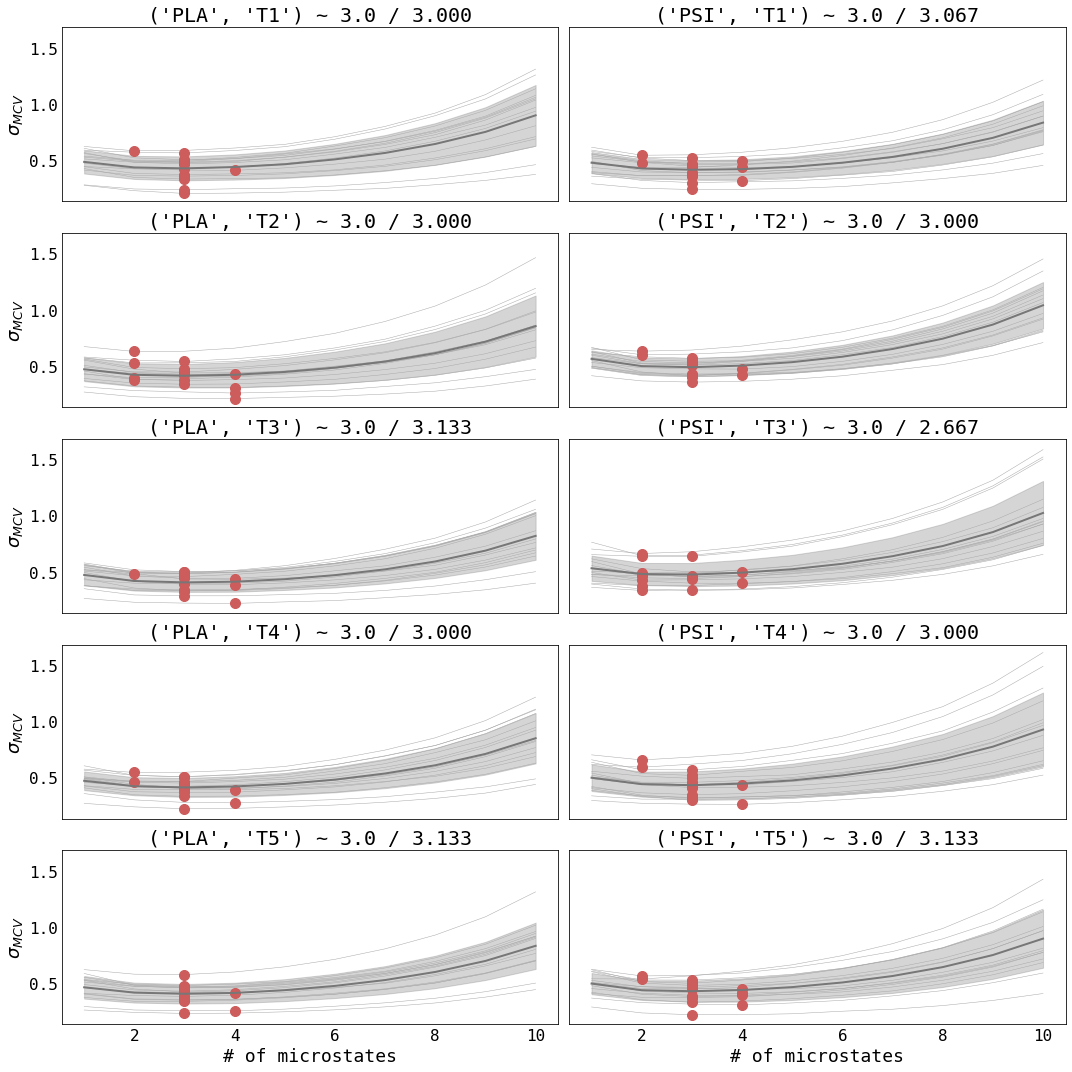

In [17]:
no_states = np.arange(1, df_140_sigma.values.shape[1] + 1)
_, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=(15, 15))
ideal_ms = pd.DataFrame(columns=["session", "ideal #"])

for i, (session, df_temp) in enumerate(df_140_sigma.groupby(level=[1, 2])):
    sigmas = df_temp.values  # (subjs x no states)
    ideal_num = sigmas.argmin(axis=1) + 1
    ideal_ms.loc[i] = [session, np.median(ideal_num)]
    jj = 0 if session[0] == "PLA" else 1
    ii = int(session[1][-1]) - 1
    axs[ii, jj].plot(no_states, sigmas.T, color="#AAAAAA", linewidth=0.5)
    axs[ii, jj].plot(ideal_num, sigmas.min(axis=1), "o", color="indianred")
    axs[ii, jj].plot(no_states, sigmas.mean(axis=0), color="C3")
    axs[ii, jj].fill_between(
        no_states,
        sigmas.mean(axis=0) - sigmas.std(axis=0),
        sigmas.mean(axis=0) + sigmas.std(axis=0),
        alpha=0.3,
        color="C3",
    )
    axs[ii, jj].set_title(
        f"{session} ~ {np.median(ideal_num)} / {ideal_num.mean():.3f}"
    )
    if jj == 0:
        axs[ii, jj].set_ylabel(r"$\sigma_{MCV}$")
    if ii == 4:
        axs[ii, jj].set_xlabel("# of microstates")

plt.tight_layout()
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(PLOTTING_DIR, f"ideal_num_ms_1-40filt{PLOT_EXT}"),
        bbox_inches="tight",
        transparent=True,
    )

In [18]:
_, _, stats = pg.chi2_independence(ideal_ms, x="session", y="ideal #")
if SAVE_RESULTS:
    stats.round(5).to_csv(os.path.join(WORKING_DIR, "ideal_num_ms_chi_sq_1-40filt.csv"))
stats

/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/pingouin/contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))
/Users/nikola/.virtualenvs/microstates/lib/python3.7/site-packages/pingouin/contingency.py:151: UserWarning: Low count on expected frequencies.
  warnings.warn('Low count on {} frequencies.'.format(name))


,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.0,0.0,1.0,NaN,NaN
1,cressie-read,0.666667,0.0,0.0,1.0,NaN,NaN
2,log-likelihood,0.000000,0.0,0.0,1.0,NaN,NaN
3,freeman-tukey,-0.500000,0.0,0.0,1.0,NaN,NaN
4,mod-log-likelihood,-1.000000,0.0,0.0,1.0,NaN,NaN
5,neyman,-2.000000,0.0,0.0,1.0,NaN,NaN


### Summary plot for ideal number of microstates

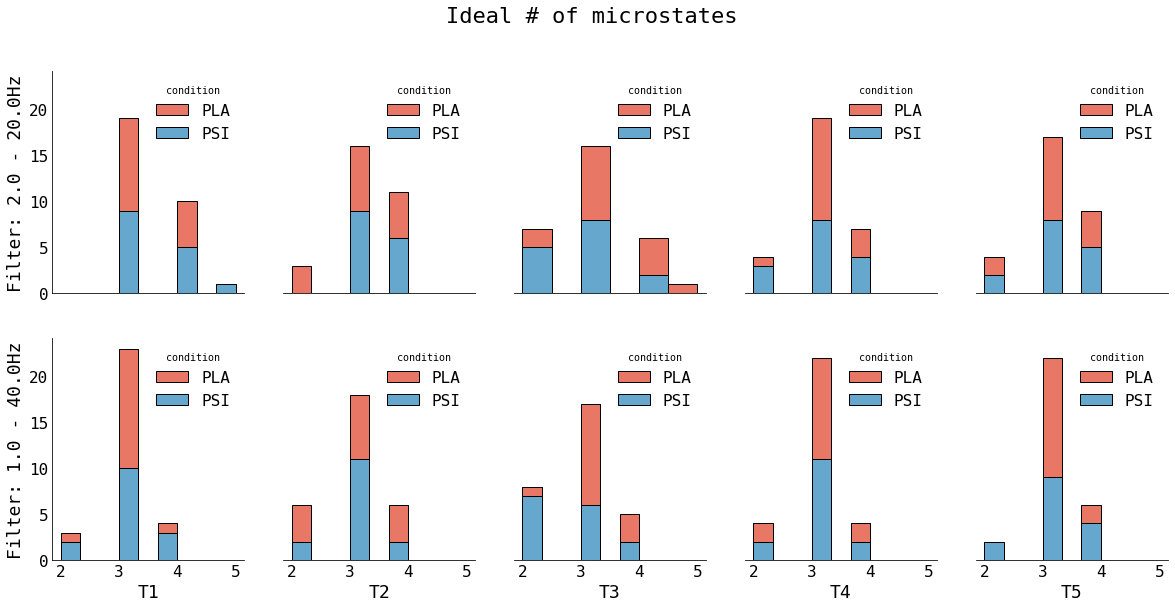

In [19]:
df_220_ideal_states = df_220_sigma.idxmin(axis=1).apply(lambda x: int(x[15]))
df_220_ideal_states.name = "ideal no. states"
df_220_plot = pd.DataFrame(df_220_ideal_states).reset_index()

df_140_ideal_states = df_140_sigma.idxmin(axis=1).apply(lambda x: int(x[15]))
df_140_ideal_states.name = "ideal no. states"
df_140_plot = pd.DataFrame(df_140_ideal_states).reset_index()

_, axs = plt.subplots(2, 5, sharey=True, sharex=True)
for i, time in enumerate(np.unique(df_220_plot["time"])):
    ax = axs[0, i]
    sns.histplot(
        data=df_220_plot[df_220_plot["time"] == time],
        x="ideal no. states",
        hue="condition",
        multiple="stack",
        ax=ax,
    )
    ax.set_xlabel(time)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if i > 0:
        ax.spines["left"].set_visible(False)
axs[0, 0].set_ylabel("Filter: 2.0 - 20.0Hz")

for i, time in enumerate(np.unique(df_140_plot["time"])):
    ax = axs[1, i]
    sns.histplot(
        data=df_140_plot[df_140_plot["time"] == time],
        x="ideal no. states",
        hue="condition",
        multiple="stack",
        ax=ax,
    )
    ax.set_xlabel(time)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if i > 0:
        ax.spines["left"].set_visible(False)
axs[1, 0].set_ylabel("Filter: 1.0 - 40.0Hz")
plt.suptitle("Ideal # of microstates")

if SAVE_RESULTS:
    plt.savefig(
        os.path.join(PLOTTING_DIR, f"ideal_num_ms_summary{PLOT_EXT}"),
        bbox_inches="tight",
        transparent=True,
    )